In [44]:
import control as ctrl
import matplotlib.pyplot as plt 
import numpy as np 
import casadi 

s = ctrl.tf('s')

G = (s/100 + 1)/(s/10 + 1)*13.37 

G

TransferFunction(array([  133.7, 13370. ]), array([ 100, 1000]))

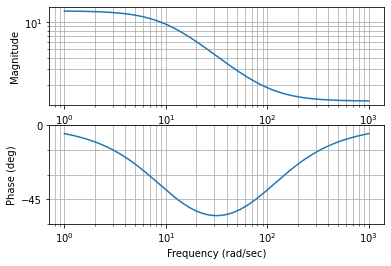

In [45]:
mag,phase,w = ctrl.bode(G)
mag = np.log10(mag)


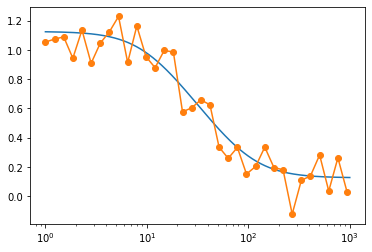

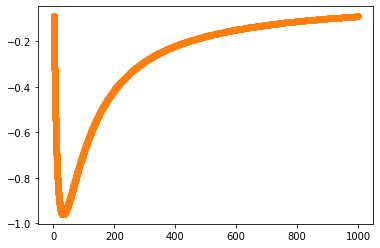

In [49]:
plt.semilogx(w,mag)

indx = np.arange(0,len(w),1)
indx = np.mod(indx,30)==0

ws = w[indx]
mags = mag[indx]
phases = phase[indx]

np.random.seed(1337)

mags += 0.1*np.random.randn(len(mags))

#phases = np.mod(phases,2*np.pi)

# Phase must start at within +/- 180 deg
if abs(phases[0]) >= np.pi:
    phases = np.mod(phases,2*np.pi)


plt.plot(ws, mags,'o-')
plt.figure()
plt.plot(ws, phases,'o-')
plt.plot(w, phase,'o-')

$$
G(s) = \dfrac{s/\omega_n + 1}{s/\omega_d + 1} k
$$

$$
|G(\omega)| = \dfrac{\sqrt{1 + (\omega/\omega_n)^2}}{\sqrt{1 + (\omega/\omega_d)^2}} k
$$

$$
|G(\omega)|_{dB} = \log\bigg(\sqrt{1 + (\omega/\omega_n)^2}\bigg) - \log\bigg(\sqrt{1 + (\omega/\omega_d)^2}\bigg)  + \log(k)
$$



$$
\angle{G(\omega)} = \arctan(\omega/\omega_n) - \arctan(\omega/\omega_d)
$$

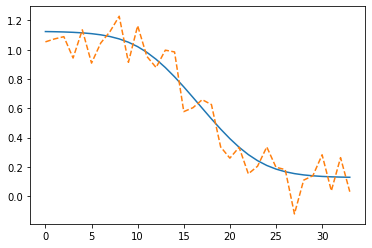

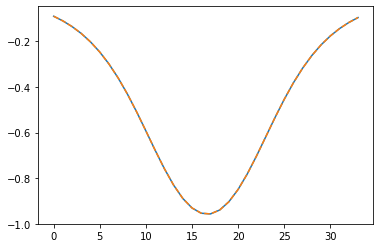

In [47]:
wn = 100
wd = 10
k = 13.37

magis = []
phis = []
for i in range(len(ws)):

    wi = ws[i]
    # Mag
    t1 = casadi.sqrt(1 + (wi/wn)**2)
    t2 = casadi.sqrt(1 + (wi/wd)**2)

    magi = casadi.log10(t1) - casadi.log10(t2) + casadi.log10(k)

    phi = casadi.arctan(wi/wn) - casadi.arctan(wi/wd) 

    magis.append(magi)
    phis.append(phi)

plt.plot(magis)
plt.plot(mags,'--')

plt.figure()
plt.plot(phis)
plt.plot(phases,'--')


In [48]:
opti = casadi.Opti()

wn = opti.variable()
wd = opti.variable()
k = opti.variable()

opti.subject_to(wn >= 1)
opti.subject_to(wd >= 1)
opti.subject_to(k >= 1)

opti.subject_to(wn <= 1000)
opti.subject_to(wd <= 1000)
opti.subject_to(k <= 1000)

opti.set_initial(wn,10)
opti.set_initial(wd,100)
opti.set_initial(k,12)


opti.set_initial(wn,1)
opti.set_initial(wd,1)
opti.set_initial(k,1)

J = 0

for i in range(len(ws)):

    wi = ws[i]
    # Mag
    t1 = casadi.sqrt(1 + (wi/wn)**2)
    t2 = casadi.sqrt(1 + (wi/wd)**2)

    magi = casadi.log10(t1) - casadi.log10(t2) + casadi.log10(k)

    phi = casadi.arctan(wi/wn) - casadi.arctan(wi/wd) 

    m_err = (mags[i] - magi)**2
    ph_err = (phases[i] - phi)**2

    J += m_err + ph_err

opti.minimize(J);

opti.solver('ipopt');
sol = opti.solve();

print(sol.value(k))
print(sol.value(wn))
print(sol.value(wd))





This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        6
Number of nonzeros in Lagrangian Hessian.............:        6

Total number of variables............................:        3
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        6
        inequality constraints with only lower bounds:        3
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        3

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.9641124e+01 0.00e+00 5.99e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00  